## Project: Analyzing NYC High School Data

For this project we will explore data from differents data sets and looking for if there is any correlation between SAT results and schools take into demographic and survey made for some schools in NY and then we will plot the results.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

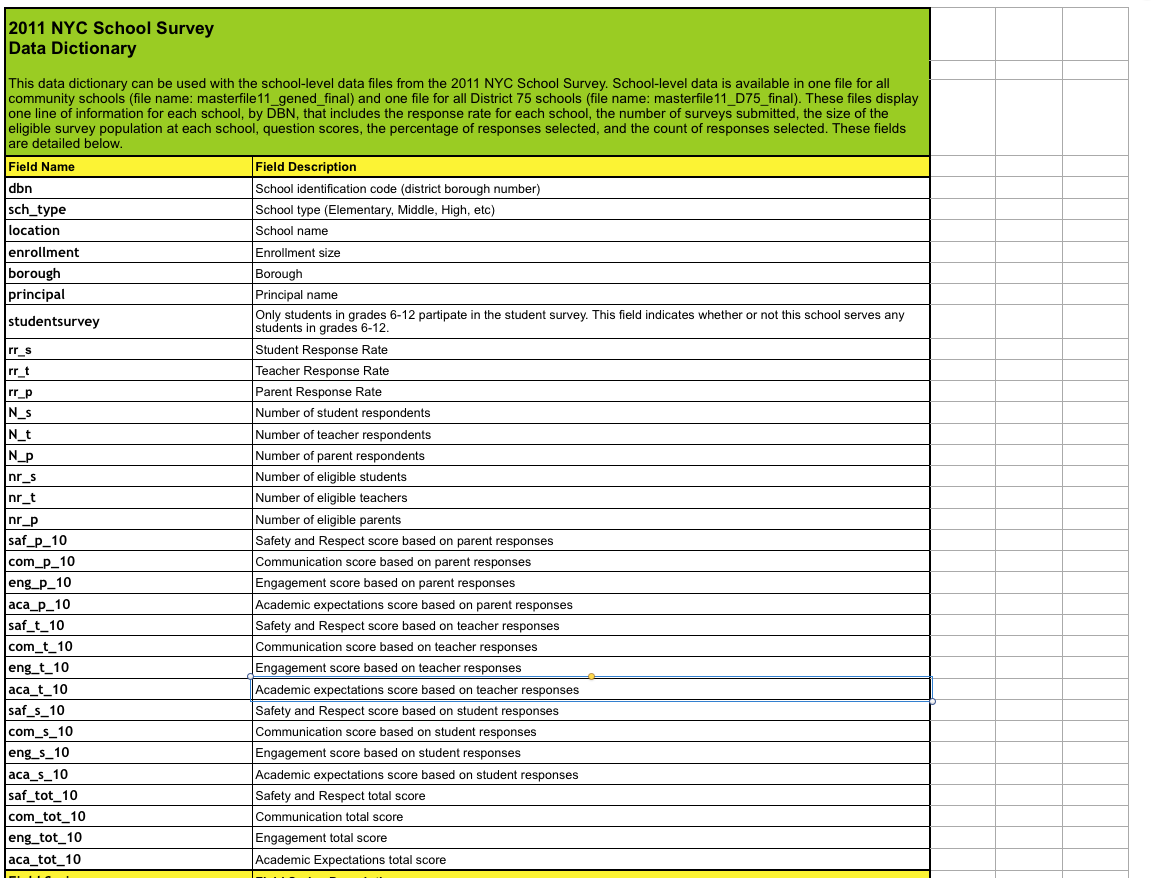

In [11]:
from IPython import display 
display.Image("https://s3.amazonaws.com/dq-content/xj5ud4r.png")

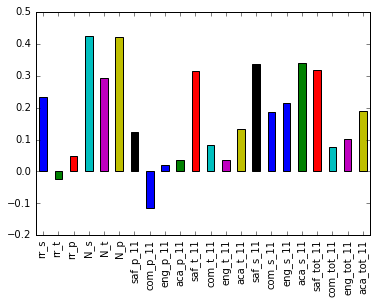

In [12]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

previous plot show us interesting findings:
N_s, N_t ans N_p are highly correlated which corresponds to number of students, teacher and parents respondents.
safety for students and teachers are strongly correlated with score, it make sense since with a safety and respectful environment is more capable to get better score.
rr_s is correlated with sat score, it is explained because when students have better scored they are more able to fill out the survey.
academics expectations for the studens are highly correlated, it means when academics expectations are higher the sat score are higher, but it does not work for teachers and parents which show that academic expectations are not correlated to sat score 

## PLOT SCATTER SAFETY VS SAT SCORE

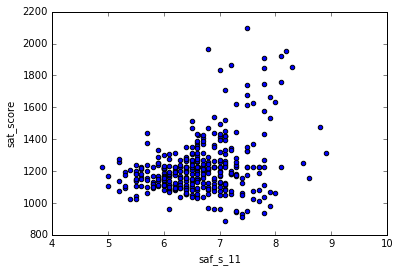

In [13]:
combined.plot.scatter("saf_s_11", "sat_score")

as per scatter plot we can see that when safety es higher the sat score es higher so they are strongly correlated, there are some schools that have low SAT score but they aso have a safety score low. However, many dots are concentrated in safety score between 5 and 8 and sat score limit for this range is almost 1600

In [14]:
combined.groupby("boro").agg(numpy.mean)["saf_s_11"]

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

the mean of students safety score is similar among boroughs in this data set, manhattan is a borough with a higher score, it make sense since manhattan is known by being the richest borough in NY

## PLOT BAR RACE VS SAT SCORE

In [15]:
race_per=["white_per","asian_per","black_per","hispanic_per"]

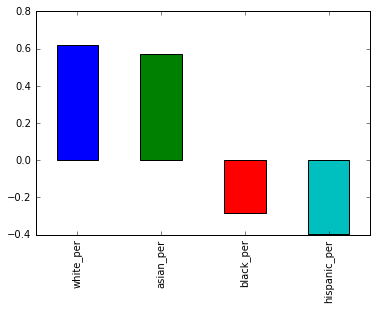

In [16]:
combined.corr()["sat_score"][race_per].plot.bar()

as we can see white and asian percentage are strongly correlated to SAT score, it means they obtain a good score but black and hispanic percentage is negative correlated which mean that when SAT score goes up black and hispanic decrease

## PLOT SCATTER HISPANIC PERCENTAGE VS SAT SCORE

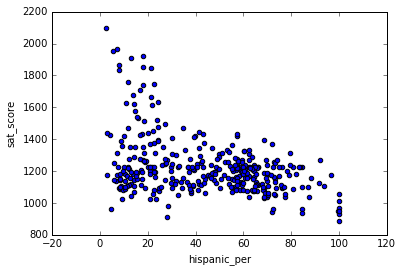

In [17]:
combined.plot.scatter("hispanic_per", "sat_score")

the plot shows when hispanic percentage is greater the sat score decrease, when school is less of hispanic the score goes up

In [18]:
combined[combined["hispanic_per"]>95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Searching these school names we can find that they are schools that caters to immigrants recently arrived from Spanish-speaking countries. 
may be de SAT score does down for these kind of school due to they are learning english and this may difficult the correct perform

In [19]:
combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["SCHOOL NAME"] 

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are specialized in technology and science and it is neccesary a entry examn to be admited to them, also it indicates that hispanic is not high in these kind of schools.

## PLOT BAR AND SCATTER MALE AND FEMALE VS SAT SCORE

In [20]:
genre=["male_per","female_per"]

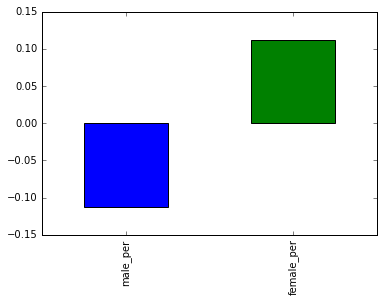

In [21]:
combined.corr()["sat_score"][genre].plot.bar()

As we can see male percentage and female percentage are  positively correlated with SAT score but male per is negatively correlated. correlation is not strong

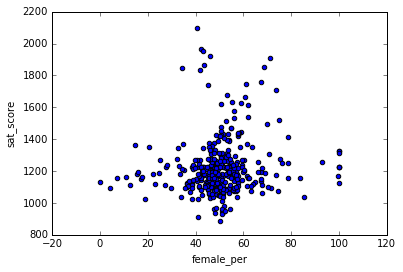

In [22]:
combined.plot.scatter("female_per", "sat_score")

It does not seems as correlation between sat score and female per.However, there is some schools with high sat score and high number of females, but most of dots are concentrated between 40 to 60 female per and with a score from almost 1000 to approximately 1700

In [23]:
combined[(combined["female_per"]>60)&(combined["sat_score"]>1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

these schools have not relation to female but they have high standards for the students enrollment

## PLOT SCATTER AP TEST TAKERS VS SAT SCORE

In [24]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

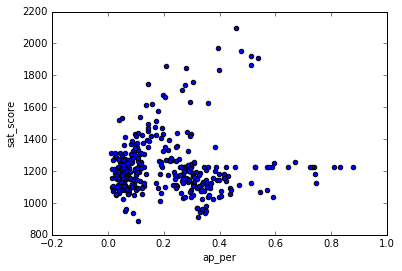

In [25]:
combined.plot.scatter("ap_per", "sat_score")

the plot shows that there is correlation between the percentage of students in a school who take the AP exam, and their average SAT scores but it is weak